# Sugar Prices

The sugar prices data is taken from [Agricultural Futures Prices (Kaggle, originally Yahoo Finance)](https://www.kaggle.com/datasets/guillemservera/agricultural-futures)

In [60]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_style
import seaborn as sns
import statsmodels.api as sm

In [ ]:
df_sugar = pd.read_csv('sugar_prices.csv')
df_sugar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6097 non-null   object 
 1   open    6097 non-null   float64
 2   high    6097 non-null   float64
 3   low     6097 non-null   float64
 4   close   6097 non-null   float64
 5   volume  6097 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 285.9+ KB


In [3]:
# make date: str -> datetime; when plotting, the date will be used as the x-axis

df_sugar['date'] = pd.to_datetime(df_sugar['date'])  # Convert string to datetime

# Set the date column as the index
df_sugar.set_index('date', inplace=True)

In [4]:
# a baseline for predicting volatility
"""
    This function takes in a dataframe df of stock prices, a metric such as 'Close',
    and a number n which is the length of array of volatilities we want.
    The function computes this by breaking the dataframe into n pieces and then
    computing volatility on each interval.
"""

""" def volatilities(df, metric, n):

    sigmas = []
    interval = len(df)//n
    for i in range(1,n):
        sigmas.append(np.var(df[(i-1)*interval:i*interval][metric]))
    sigmas.append(np.var(df[(n-1)*interval:n*interval][metric]))
    return sigmas """

def volatilities(df, metric, n=30):
    """
    This function takes in a dataframe df of stock prices in yf format
    and a number n which is the length of array (equal to # of days) of 
    volatilities we want.  The function computes volatility per day by
    taking the previous n datapoints (default is set to n = 30 days)
    and then computing the standard deviation in closing price on each
    interval (intraday changes can improve this measure).

    Typical range for n is 10 to 365 trading days.

    Sigma array provides data for original df (with zero volatility for
    first n days)
    """
    sigmas = []
    n_chunks = len(df)//n
    for i in range(n,len(df)):
        sigmas.append(np.std(df[i-n:i][metric]))
    sigmas = np.insert(sigmas, 0, np.full((n), 0)) # makes the array length n, the lengthening uses 0's
    return sigmas


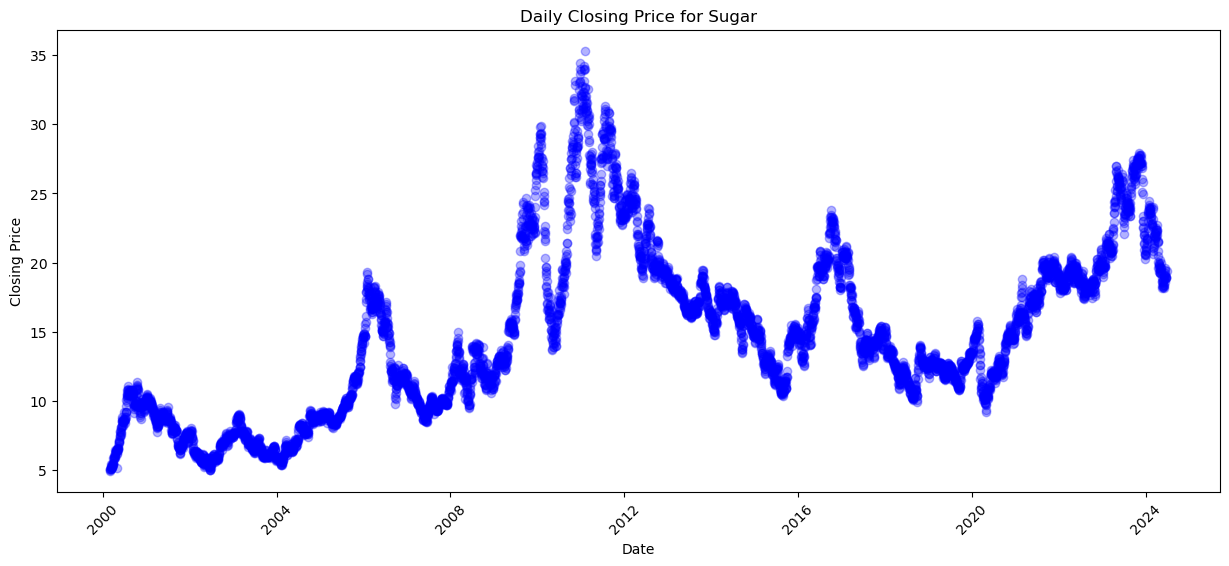

In [5]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, df_sugar['close'], color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Sugar')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [6]:
rolling_sigmas_sugar = volatilities(df_sugar,'close',n=30)

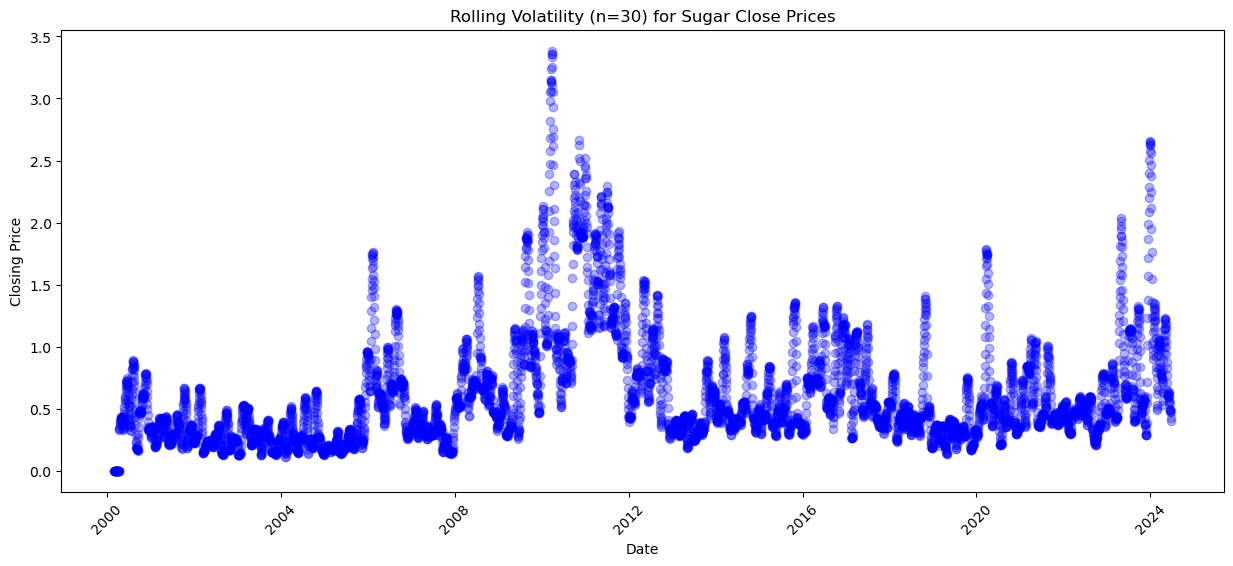

In [7]:
# Plot daily closing price
plt.figure(figsize=(15, 6))
plt.scatter(df_sugar.index, rolling_sigmas_sugar, color = 'b', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

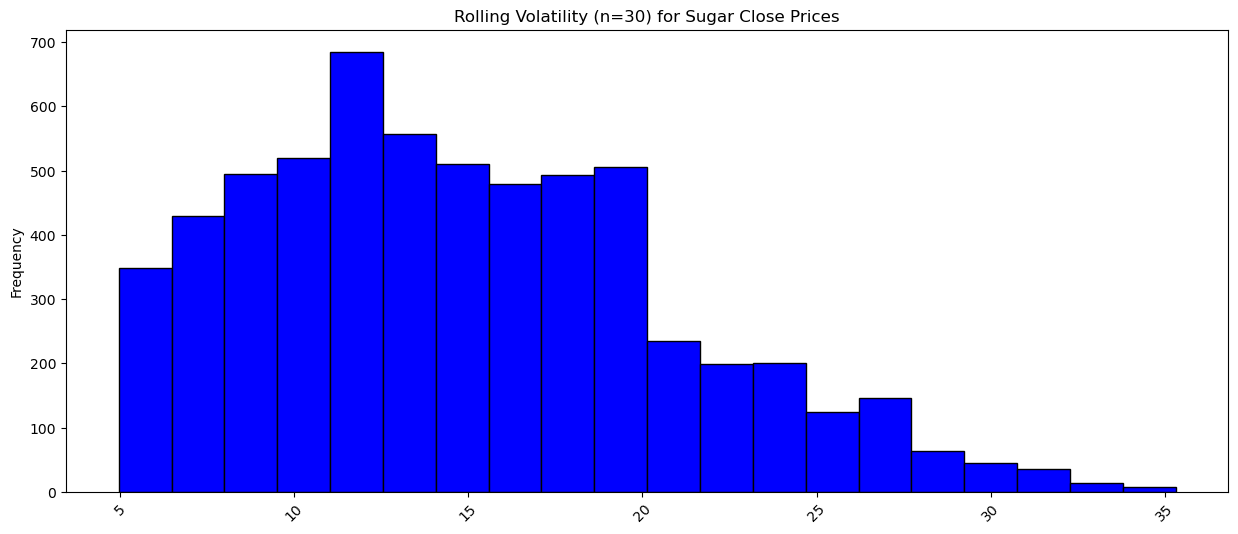

In [8]:
# histogram
plt.figure(figsize=(15, 6))
plt.hist(df_sugar['close'], bins=20, edgecolor='black',color = 'b')
plt.ylabel('Frequency')
plt.title('Rolling Volatility (n=30) for Sugar Close Prices')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

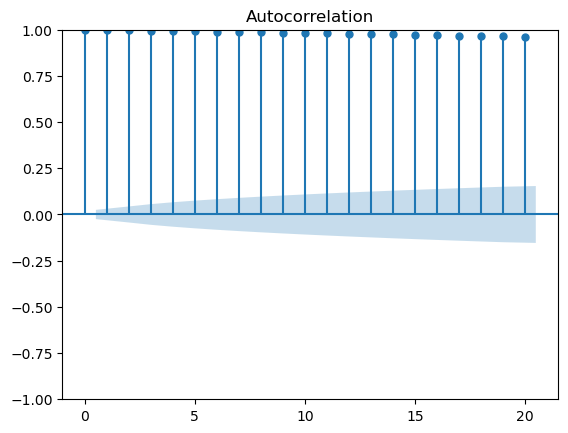

In [9]:
sm.graphics.tsa.plot_acf(df_sugar['close'], lags = 20) # correlation between X and a delayed copy of itself, up to 20 lages
plt.show()

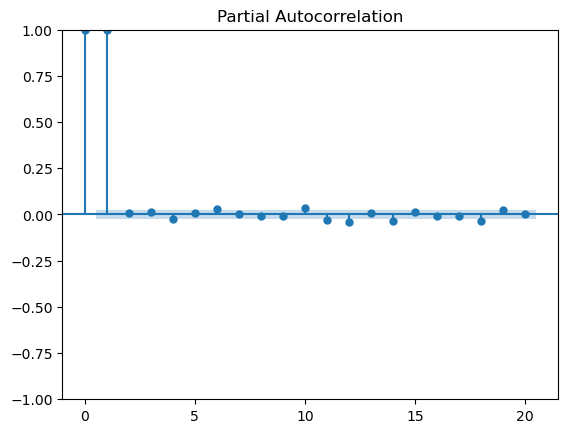

In [10]:
# Partial autocorrelation is a statistical measure in time series analysis that represents the correlation between an observation 
# and its lagged values, while accounting for the influence of all the intervening lags, essentially isolating the direct 
# relationship between two points in time without the effect of other intermediary observations

sm.graphics.tsa.plot_pacf(df_sugar['close'], lags = 20)
plt.show()

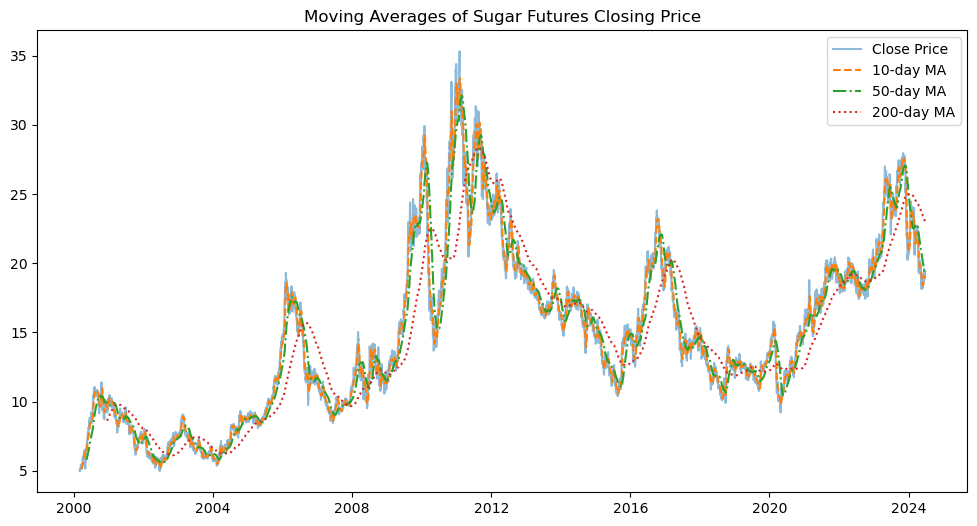

In [11]:
# Moving Averages
df_sugar["MA_10"] = df_sugar["close"].rolling(window=10).mean()
df_sugar["MA_50"] = df_sugar["close"].rolling(window=50).mean()
df_sugar["MA_200"] = df_sugar["close"].rolling(window=200).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_sugar["close"], label="Close Price", alpha=0.5)
plt.plot(df_sugar["MA_10"], label="10-day MA", linestyle="--")
plt.plot(df_sugar["MA_50"], label="50-day MA", linestyle="-.")
plt.plot(df_sugar["MA_200"], label="200-day MA", linestyle=":")
plt.legend()
plt.title("Moving Averages of Sugar Futures Closing Price")
plt.show()

In [12]:
# for seasonal decomposition
from statsmodels.tsa.seasonal import STL

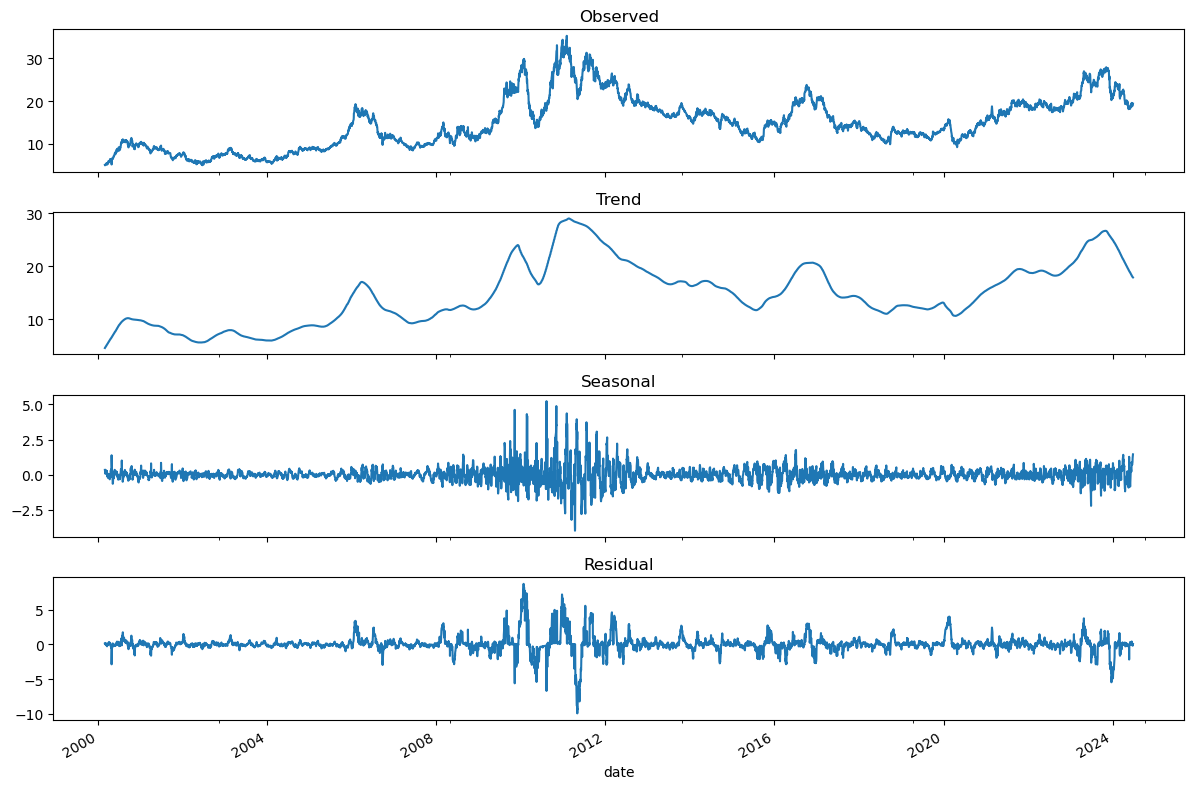

In [13]:
# Seasonal Decomposition (Using STL)
stl = STL(df_sugar["close"], period=60,robust=True)  # 5 day period (since weekends are excluded)
res = stl.fit()

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res.observed.plot(ax=axes[0], title="Observed") # original prices
res.trend.plot(ax=axes[1], title="Trend") # smooths out short term fluctuations to find long-term movement
res.seasonal.plot(ax=axes[2], title="Seasonal") # tries to find repeating patterns
res.resid.plot(ax=axes[3], title="Residual") # what remains after removing trend and seaonality
plt.tight_layout()
plt.show()


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [15]:
split_index = int(len(df_sugar)*0.8)
df_train = df_sugar[:split_index]['close']
df_test = df_sugar[split_index:]['close']

In [16]:
len(df_train)+len(df_test)==len(df_sugar)

True

In [17]:
# Perform ADF test to check for stationarity
result = adfuller(df_sugar['close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -2.5858266512872627
p-value: 0.09596213580817703


In [18]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
model = SARIMAX(df_train, order=(30, 1, 1), seasonal_order=(0, 1, 0, 12))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())


/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usi

                                      SARIMAX Results                                       
Dep. Variable:                                close   No. Observations:                 4877
Model:             SARIMAX(30, 1, 1)x(0, 1, [], 12)   Log Likelihood               -2407.358
Date:                              Thu, 20 Feb 2025   AIC                           4878.715
Time:                                      16:24:53   BIC                           5086.383
Sample:                                           0   HQIC                          4951.601
                                             - 4877                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054     11.733      0.000      1.000     -22.991      23.001
ar.L2          0.00

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


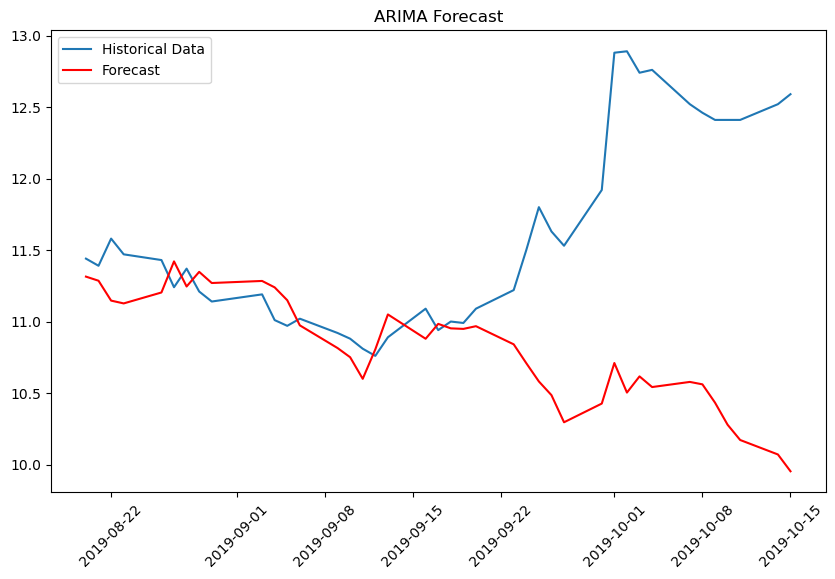

In [ ]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = 40 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import r2_score

days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviaiton of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print()

Days = 5
Standard deviaiton of test data: 0.0719026003718356
Root MSE: 0.27714284966592506
R^2 score: -17.570695772196252

Days = 10
Standard deviaiton of test data: 0.14338760803331566
Root MSE: 0.21834814153522647
R^2 score: -1.5765184111439234

Days = 15
Standard deviaiton of test data: 0.22294984511973653
Root MSE: 0.19855282674998123
R^2 score: 0.15023072914569413

Days = 20
Standard deviaiton of test data: 0.24535412187285377
Root MSE: 0.18834328417469787
R^2 score: 0.3797168896234825

Days = 25
Standard deviaiton of test data: 0.2349112718561194
Root MSE: 0.2448088920091063
R^2 score: -0.13129386283142197

Days = 30
Standard deviaiton of test data: 0.4244765287040269
Root MSE: 0.6521216023927682
R^2 score: -1.4415918619782224



Rule 11.06. Last Trading Day
(a) The Last Trading Day for each delivery month in the Sugar No. 11 Contract shall be the last full
trading day of the month preceding the delivery month.

Unless the Board directs otherwise, trading shall be limited to sugar deliverable in the delivery
months of January, March, May, July, and October

[See here](https://www.ice.com/publicdocs/rulebooks/futures_us/11_Sugar_11.pdf) and [here](https://www.ice.com/products/23/Sugar-No-11-Futures) for info on Sugar No. 11 futures trading. The Sugar No. 11 contract is the world benchmark contract for raw sugar trading. The contract prices the physical delivery of raw cane sugar, free-on-board the receiver's vessel to a port within the country of origin of the sugar.

# Trying Tianhao's utility functions

In [ ]:
sugar_futures = yf.Ticker('SB=F')
df_sugar_futures = sugar_futures.history(period='max')
df_sugar_futures
#pd.read_csv('sugar_prices2.csv')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-03-01 00:00:00-05:00,4.980000,5.140000,4.980000,5.080000,10467,0.0,0.0
2000-03-02 00:00:00-05:00,5.080000,5.130000,4.940000,4.960000,9638,0.0,0.0
2000-03-03 00:00:00-05:00,4.960000,5.060000,4.960000,5.050000,5879,0.0,0.0
2000-03-06 00:00:00-05:00,5.100000,5.160000,5.030000,5.040000,11290,0.0,0.0
2000-03-07 00:00:00-05:00,5.050000,5.140000,5.030000,5.070000,9369,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-14 00:00:00-05:00,20.150000,20.450001,20.049999,20.420000,51960,0.0,0.0
2025-02-17 00:00:00-05:00,20.150000,20.450001,20.049999,20.420000,0,0.0,0.0
2025-02-18 00:00:00-05:00,20.500000,20.719999,20.469999,20.520000,70737,0.0,0.0


In [ ]:
from pandas.tseries.offsets import BDay, MonthEnd

In [31]:
ALLOWED_DELIVERY_MONTHS = [1, 3, 5, 7, 10]

def get_expiry(dt):
    """
    Given a timestamp dt, returns the expiry date as the last trading day of the month
    preceding the next allowed delivery month.
    """
    dt = pd.Timestamp(dt)
    # Loop through allowed delivery months (sorted in ascending order)
    for m in sorted(ALLOWED_DELIVERY_MONTHS):
        # For the current year, build the delivery date as the first day of month m
        delivery_date = pd.Timestamp(year=dt.year, month=m, day=1)
        # Expiry is defined as the last day of the month preceding the delivery month
        expiry = delivery_date + MonthEnd(-1)
        # Adjust expiry to the last business day if it falls on a weekend
        if expiry.weekday() >= 5:  # Saturday=5, Sunday=6
            expiry -= BDay(1)
        # Check if this expiry is still in the future relative to dt
        if expiry > dt:
            return expiry

    # If no delivery month in the current year qualifies, use the first allowed month of next year
    m = sorted(ALLOWED_DELIVERY_MONTHS)[0]
    delivery_date = pd.Timestamp(year=dt.year+1, month=m, day=1)
    expiry = delivery_date + MonthEnd(-1)
    if expiry.weekday() >= 5:
        expiry -= BDay(1)
    return expiry

In [51]:
def extend_market_data(df):
    """
    :param df: The pandas dataframe obtained from yfinance library
    :return: The extended market data
    """
    ########################################################
    # Seasonality & Time Features
    # remove time zone featuress
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Day_Of_Year'] = df.index.dayofyear
    # get the expiry date of this specific contract
    
    # df["expiry"] = df.index.map(lambda x: expiry_series[expiry_series >= x].iloc[0])

    df['expiry'] = df.index.to_series().apply(get_expiry)
    # df['expiry'] = df['datetime'].apply(get_expiry)
   
    # computing the days to expiry
    df["DTE"] = (df["expiry"] - df.index).dt.days

    ##############################################################
    # Volatility Features:
    # Historical Volatility
    df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))
    df['7D_Volatility'] = df['Log_Return'].rolling(window=7).std()
    df['14D_Volatility'] = df['Log_Return'].rolling(window=14).std()
    # Average True Range (ATR)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['14D_ATR'] = df['TR'].rolling(window=14).mean()
    # Volume-to-Volatility Ratio
    df['Volume_Volatility_Ratio'] = df['Volume'] / df['14D_Volatility']

    ##############################################################
    # Momentum Indicator Features:
    # Relative Strength Index (RSI)
    # Measures the speed and change of price movements.
    # Values above 70 indicate overbought conditions, below 30 indicate oversold conditions.
    delta =df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df[f'14D_RSI'] = 100 - (100 / (1 + rs))

    ###############################################################
    # Trend Indicator Features:
    # Moving Average
    df['7D_MA'] = df['Close'].rolling(window=7).mean()
    df['14D_MA'] = df['Close'].rolling(window=14).mean()
    # Exponential Moving Average (EMA)
    # A weighted version of moving average giving more weight to recent prices.
    df['7D_EMA'] = df['Close'].ewm(span=7, adjust=False).mean()
    df['14D_EMA'] = df['Close'].ewm(span=14, adjust=False).mean()

    return df

In [56]:
df = extend_market_data(df_sugar_futures)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Day,...,High-Close,Low-Close,TR,14D_ATR,Volume_Volatility_Ratio,14D_RSI,7D_MA,14D_MA,7D_EMA,14D_EMA
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,4.980000,5.140000,4.980000,5.080000,10467,0.0,0.0,2000,3,1,...,NaN,NaN,0.160000,NaN,NaN,NaN,NaN,NaN,5.080000,5.080000
2000-03-02,5.080000,5.130000,4.940000,4.960000,9638,0.0,0.0,2000,3,2,...,0.050000,0.140000,0.190000,NaN,NaN,NaN,NaN,NaN,5.050000,5.064000
2000-03-03,4.960000,5.060000,4.960000,5.050000,5879,0.0,0.0,2000,3,3,...,0.100000,0.000000,0.100000,NaN,NaN,NaN,NaN,NaN,5.050000,5.062133
2000-03-06,5.100000,5.160000,5.030000,5.040000,11290,0.0,0.0,2000,3,6,...,0.110000,0.020000,0.130000,NaN,NaN,NaN,NaN,NaN,5.047500,5.059182
2000-03-07,5.050000,5.140000,5.030000,5.070000,9369,0.0,0.0,2000,3,7,...,0.100000,0.010000,0.110000,NaN,NaN,NaN,NaN,NaN,5.053125,5.060625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,20.150000,20.450001,20.049999,20.420000,51960,0.0,0.0,2025,2,14,...,0.280001,0.120001,0.400002,0.442857,4.709083e+06,73.234213,19.807143,19.630714,19.915714,19.655164
2025-02-17,20.150000,20.450001,20.049999,20.420000,0,0.0,0.0,2025,2,17,...,0.030001,0.370001,0.400002,0.436429,0.000000e+00,72.623592,19.928572,19.715714,20.041786,19.757142
2025-02-18,20.500000,20.719999,20.469999,20.520000,70737,0.0,0.0,2025,2,18,...,0.299999,0.049999,0.299999,0.437143,6.483195e+06,71.314749,20.094286,19.792143,20.161339,19.858856


# Volume Analysis

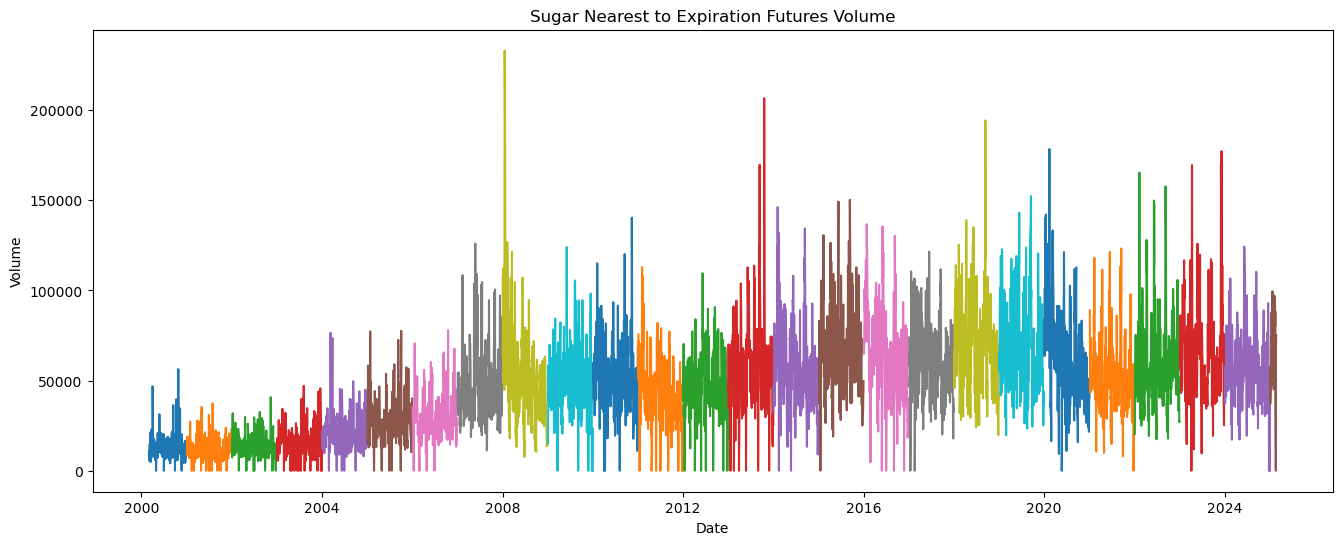

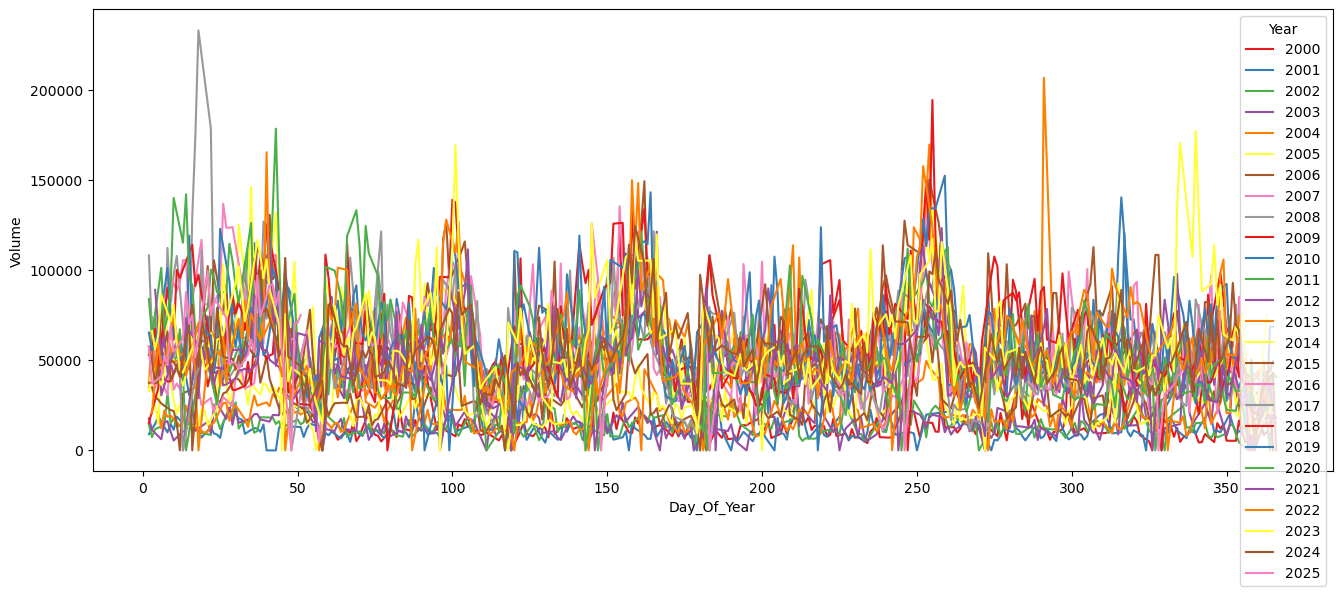

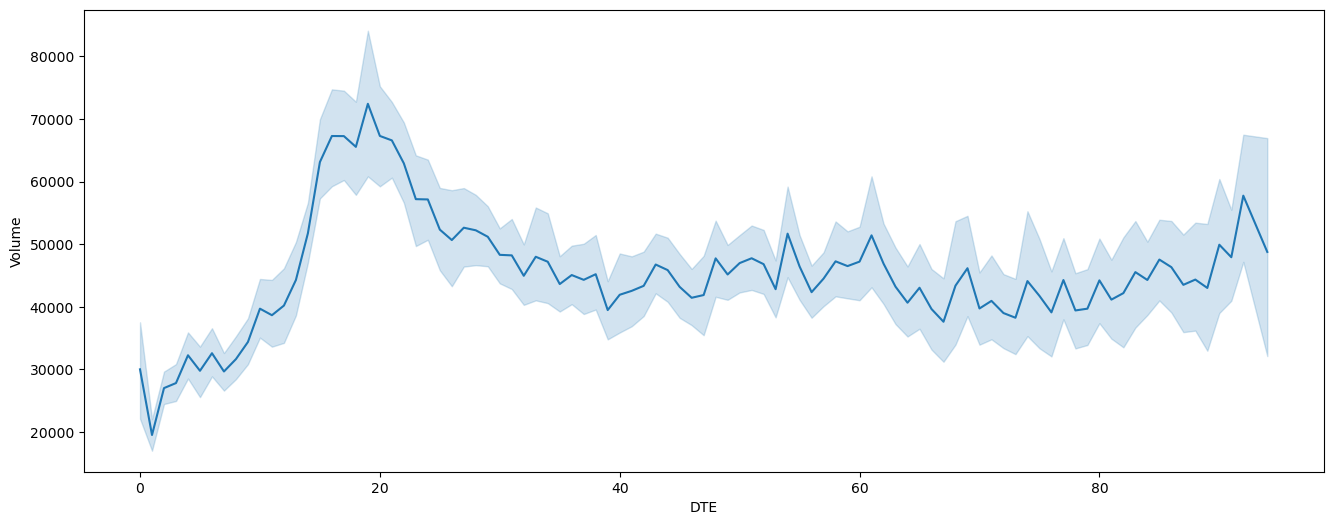

In [61]:
plt.figure(figsize = (16,6))
plt.title("Sugar Nearest to Expiration Futures Volume")
for year in df['Year'].unique():  # Loop through each unique year
    yearly_data = df[df['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Volume', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Volume', data = df, hue ='Year', palette='Set1')
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'DTE', y = 'Volume', data = df)
plt.show()

# Price Analysis

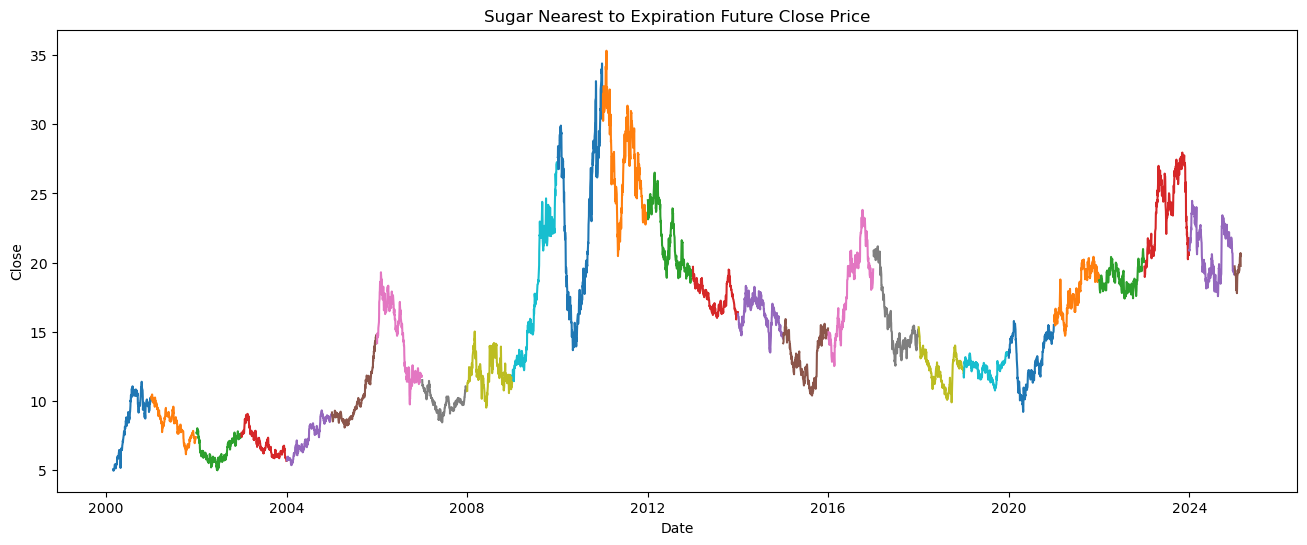

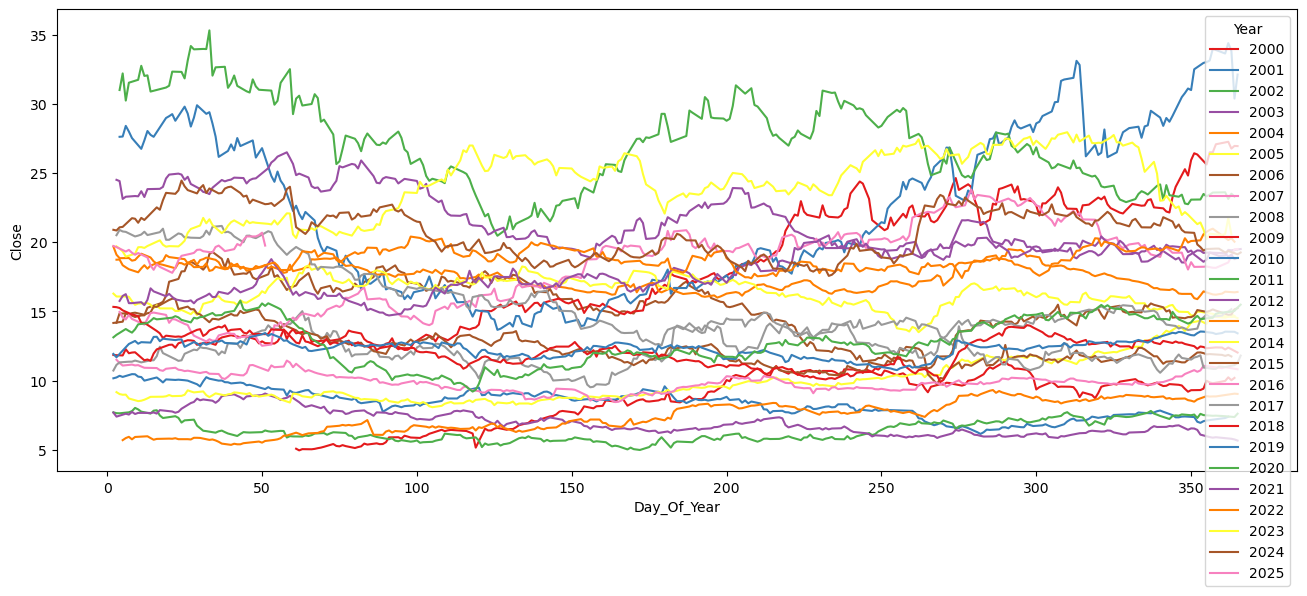

In [62]:
plt.figure(figsize = (16,6))
plt.title("Sugar Nearest to Expiration Future Close Price")
for year in df['Year'].unique():  # Loop through each unique year
    yearly_data = df[df['Year'] == year]
    sns.lineplot(x = 'Date', y = 'Close', data = yearly_data)
plt.show()

plt.figure(figsize = (16,6))
sns.lineplot(x = 'Day_Of_Year', y = 'Close', data = df, hue ='Year', palette='Set1')
plt.show()


count    6263.000000
mean        0.000217
std         0.020934
min        -0.180382
25%        -0.011413
50%         0.000000
75%         0.011895
max         0.235470
Name: Log_Return, dtype: float64


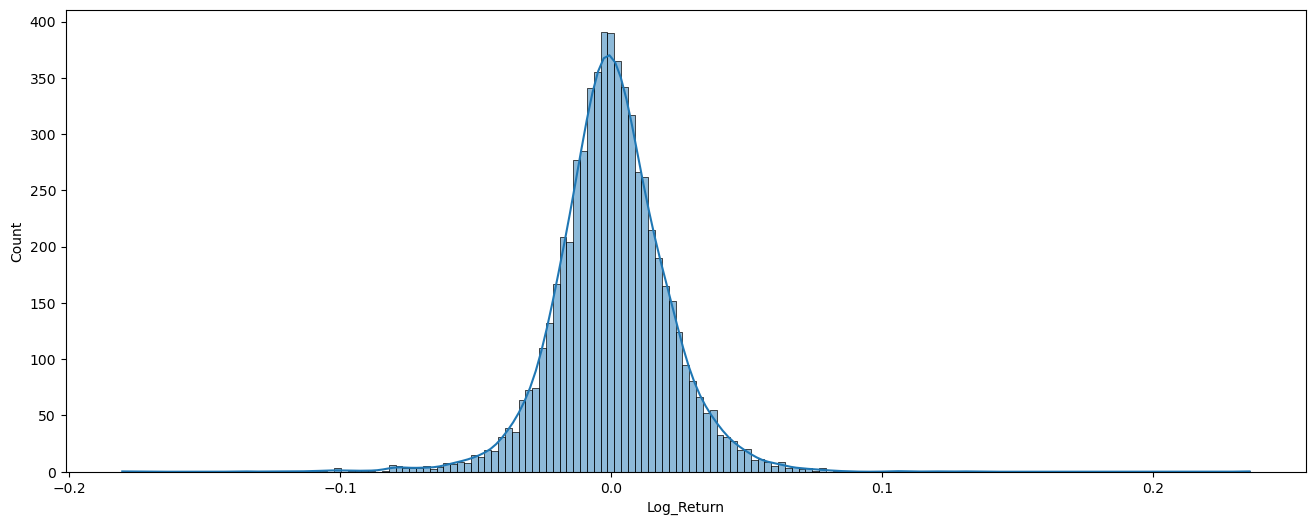

In [64]:
plt.figure(figsize = (16,6))
sns.histplot(df['Log_Return'], kde = True)
print(df['Log_Return'].describe())

The log Return is $R_t = \ln(P_t/P_{t-1}) = \ln(P_t)-\ln(P_{t-1})$. If we assume that prices behave like geometric Brownian motion (GBM), it means that the increments $\ln(P_t)-\ln(P_{t-1})$ are normally distributed. This is because GBM assumes that the price $P_t$ evolves according to a stochastic differential equation where the logarithm of the price follows a Brownian motion with drift. But remember, for Brownian motion with drift, the differences have a normal distribution depending on the difference in the time increments. For a time step of 1, it's $N(\mu-\sigma^2/2,\sigma^2)$ where $\mu$ and $\sigma$ are the drift and volatility.

Suppose we have a stochastic process $X_t$ that satisfies $dX_t = \mu_t dt + \sigma_t dW_t$ where $W_t$ is the standard Brownian motion (Wiener process). Let $f(t,X_t)$ be a twice-differentiable function. Itô's lemma tells us how to compute the differential $df$.
$df(t,X_t) = \dfrac{\partial f}{\partial t} dt + \dfrac{\partial f}{\partial x} dX_t + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} (dX_t)^2$.

Essentially, it's like the usual chain rule but we have an extra term to account for the noisiness. It looks kind of weird because in usual calculus, $dx \wedge dx = 0$ but here, because of stochasticity, $(dX_t)\cdot (dX_t) =\mu^2_t dt \wedge dt + \mu_t(dt \wedge dW_t + dW_t \wedge dt) + \sigma^2_t dW_t \neq 0$. As usual, $dt \wedge dt = 0$ and in fact, so is $dt \wedge dW_t$. On the other hand, the property of the Wiener process is that $(dW_t)^2 = dt$ (recall $W_{t_2}-W_{t_1} \sim N(0,t_2-t_1)$).

So $df(t,X_t) = \dfrac{\partial f}{\partial t} dt + \dfrac{\partial f}{\partial x} (\mu_t dt + \sigma_t dW_t) + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} \sigma^2_t dt = \left(\dfrac{\partial f}{\partial t} + \mu_t \dfrac{\partial f}{\partial x} + \dfrac{1}{2}\dfrac{\partial^2 f}{\partial x^2} \sigma^2_t \right) dt + \sigma_t \dfrac{\partial f}{\partial x} dW_t$.

If we then assume $P_t$ evolves like GBM, then $dP_t = \mu P_t dt + \sigma P_t dW_t$. We're interested in the process $Y_t = \ln(P_t)$. So $f(P_t)=\ln(P_t)$ and $\partial_P f = 1/P_t$ and $\partial^2_P f = -1/P^2_t$.

Then Itô's lemma says $dY_t = \dfrac{1}{P_t} dP_t - \dfrac{1}{2}\dfrac{1}{P^2_t} (dP_t)^2$. Subbing in $(dP_t)^2 = \sigma^2 P^2_t dt$ and $dP_t = \mu P_t dt + \sigma P_t dW_t$, we get $dY_t = (\mu - \frac{1}{2}\sigma^2)dt + \sigma dW_t$. This last equation shows that $Y_t = \ln(P_T)$ follows an arithmetic Brownian motion with drift $\mu - \frac{1}{2}\sigma^2$ and volatility $\sigma$.

### There's basically no seasonality

/var/folders/_d/c5j2kkcx3jvfgg9tymcv58yr0000gn/T/ipykernel_31649/112450169.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / frequencies, power)


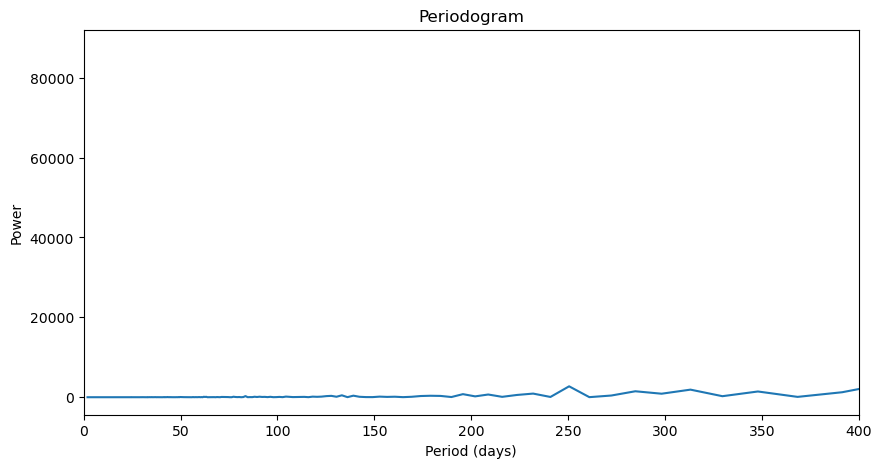

In [65]:
from scipy.signal import periodogram

frequencies, power = periodogram(df['Close'].dropna())

plt.figure(figsize=(10, 5))
plt.plot(1 / frequencies, power)
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.xlim(0, 400)  # Limit x-axis to reasonable periods
plt.show()

# ARIMA for log Returns

In [84]:
split_index = int(len(df)*0.9) # try giving it 90% of data to train on
df_train = df[:split_index]['Log_Return']
df_test = df[split_index:]['Log_Return']

As a reminder for SARIMA (though I don't anticipate seasonality so will really just do ARIMA)

* $p$ (autoregressive order):
This is the number of lagged observations included in the model. Essentially, it tells the model how many past values of the series to use as predictors.

* $q$ (moving average order):
This represents the number of lagged forecast errors (residuals) to include. It helps model the error term as a linear combination of past error terms.

In [85]:
# Fit a SARIMA model with seasonal order (p, d, q, s)
# should do a grid search eventually
model = SARIMAX(df_train, order=(30, 0, 10), seasonal_order=(0, 0, 0, 0))  # (p, d, q, s)
model_fit = model.fit()

# Summary of the ARIMA model
print(model_fit.summary())

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Usi

                               SARIMAX Results                                
Dep. Variable:             Log_Return   No. Observations:                 5637
Model:             SARIMAX(30, 0, 10)   Log Likelihood               13726.813
Date:                Sat, 22 Feb 2025   AIC                         -27371.626
Time:                        10:34:34   BIC                         -27099.504
Sample:                             0   HQIC                        -27276.828
                               - 5637                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1038      0.375      0.276      0.782      -0.632       0.840
ar.L2          0.1646      0.325      0.507      0.612      -0.472       0.801
ar.L3         -0.1584      0.324     -0.489      0.6

/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


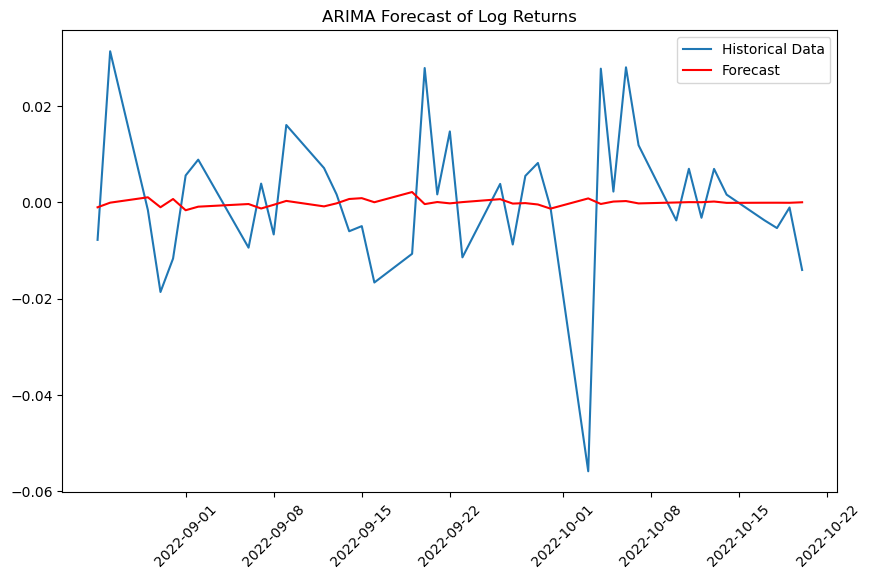

In [86]:
# Make predictions (forecast) on the same dataset (for simplicity, we're using the same data for both)
forecast_steps = 40 # Number of periods you want to predict
forecast = model_fit.forecast(steps=forecast_steps)

# Visualizing the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test[:forecast_steps], label='Historical Data')
plt.plot(df_test.index[:forecast_steps], forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Log Returns')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [87]:
days = [5,10,15,20,25,30]
for day in days:
    print(f'Days = {day}')
    print('Standard deviaiton of test data:', df_test[:day].std())
    print('Root MSE:', rmse(df_test[:day],forecast[:day]))
    print('R^2 score:', r2_score(df_test[:day],forecast[:day]))
    print()

Days = 5
Standard deviaiton of test data: 0.01945873170265596
Root MSE: 0.017331787279844354
R^2 score: 0.00832890854463253

Days = 10
Standard deviaiton of test data: 0.014072806818825188
Root MSE: 0.01340111626294621
R^2 score: -0.007576404160967165

Days = 15
Standard deviaiton of test data: 0.012401655601062277
Root MSE: 0.012080610554897744
R^2 score: -0.016673862065255562

Days = 20
Standard deviaiton of test data: 0.01359919846957711
Root MSE: 0.013516154652213189
R^2 score: -0.0398149934217118

Days = 25
Standard deviaiton of test data: 0.01265484836604489
Root MSE: 0.012607272195766576
R^2 score: -0.03384905382124748

Days = 30
Standard deviaiton of test data: 0.017141696929942454
Root MSE: 0.01707200994347081
R^2 score: -0.026088787964190008



## Compare to corn since corn syrup is widely used in the US while there are tariffs on imported sugar.

In [ ]:
corn = yf.Ticker('ZCH25.CBT')
df_corn = corn.history(period = 'max')
df_corn

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-14 00:00:00-05:00,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15 00:00:00-05:00,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16 00:00:00-05:00,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19 00:00:00-05:00,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20 00:00:00-05:00,570.00,570.00,565.50,565.50,1,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-12 00:00:00-05:00,483.75,492.25,481.50,490.25,271391,0.0,0.0
2025-02-13 00:00:00-05:00,489.75,494.25,485.25,493.50,269316,0.0,0.0
2025-02-14 00:00:00-05:00,493.00,499.75,492.50,496.25,195600,0.0,0.0


In [ ]:
# Make both indices timezone-naive (some datetime stamps are aware of the time zone)
df_sugar.index = df_sugar.index.tz_localize(None)
df_corn.index = df_corn.index.tz_localize(None)

df_merged = pd.merge(df_sugar, df_corn, left_index=True, right_index=True, how='inner')

In [ ]:
df_merged.head()

,open,high,low,close,volume,MA_10,MA_50,MA_200,Open,High,Low,Close,Volume,Dividends,Stock Splits
2022-12-14,19.660000,20.410000,19.590000,20.290001,98681,19.623,19.0520,18.83290,567.75,567.75,567.75,567.75,0,0.0,0.0
2022-12-15,20.280001,20.730000,19.860001,19.980000,105852,19.659,19.0926,18.83960,569.25,569.25,569.25,569.25,1,0.0,0.0
2022-12-16,19.879999,20.290001,19.799999,20.090000,53257,19.720,19.1252,18.84540,560.00,567.50,560.00,567.50,1,0.0,0.0
2022-12-19,20.100000,20.430000,20.030001,20.139999,52544,19.779,19.1544,18.84935,567.50,567.50,567.50,567.50,0,0.0,0.0
2022-12-20,20.150000,20.700001,20.139999,20.580000,74725,19.898,19.1938,18.85590,570.00,570.00,565.50,565.50,1,0.0,0.0


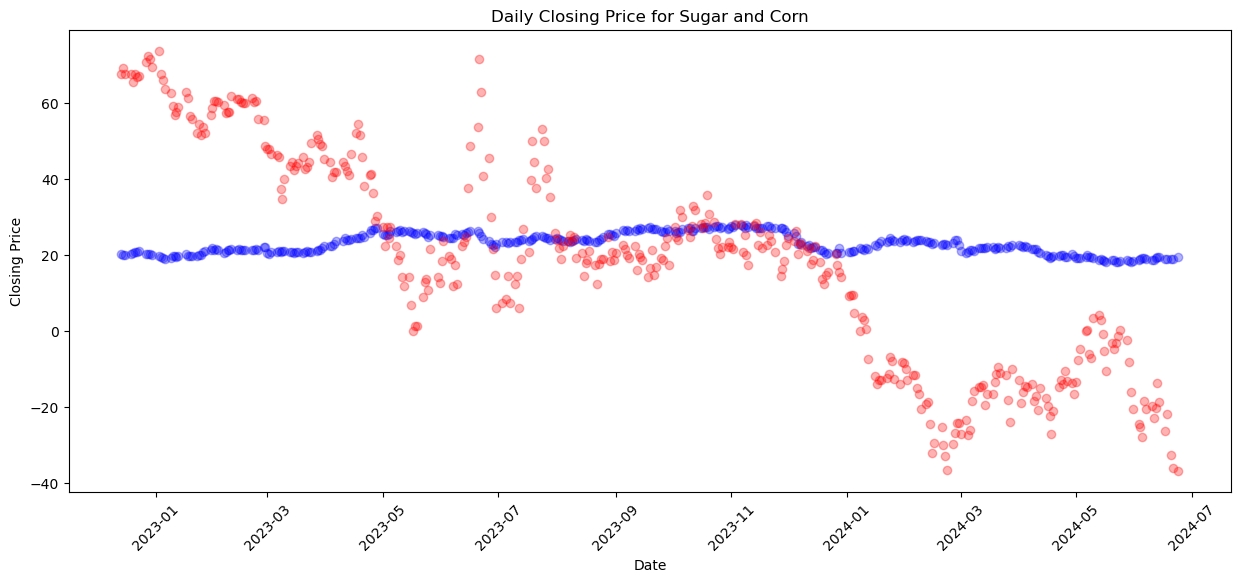

In [ ]:
# Plot daily closing price

plt.figure(figsize=(15, 6))
plt.scatter(df_merged.index, df_merged['close'], label='Dataset 1', color='blue',alpha=0.3) # sugar
plt.scatter(df_merged.index, df_merged['Close']-500, label='Dataset 2', color='red',alpha=0.3) # corn but shifted down


plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Daily Closing Price for Sugar and Corn')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

We'll try standardizing each dataset.

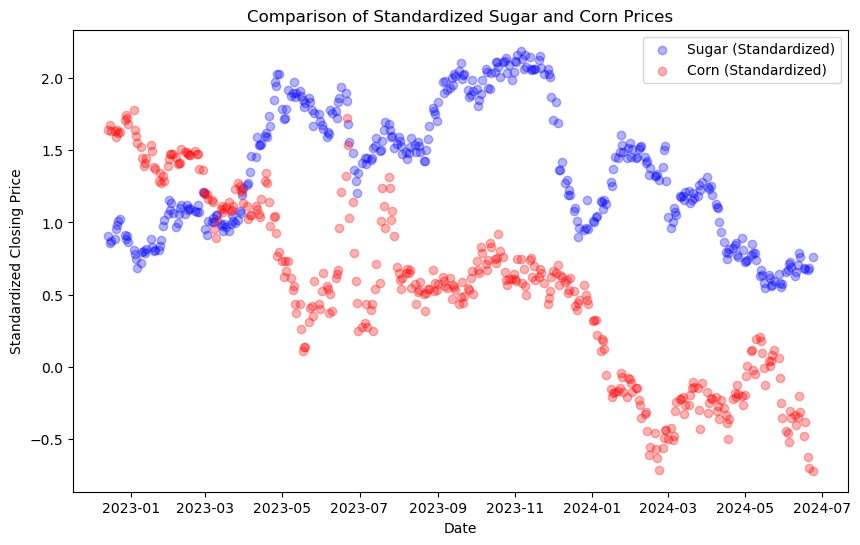

In [ ]:
# Standardize each dataset (Z-score normalization)
df_sugar_standard = (df_sugar['close'] - df_sugar['close'].mean()) / df_sugar['close'].std()
df_corn_standard = (df_corn['Close'] - df_corn['Close'].mean()) / df_corn['Close'].std()
df_merged_standard = pd.merge(df_sugar_standard, df_corn_standard, left_index=True, right_index=True, how='inner')

# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged_standard.index, df_merged_standard['close'], label='Sugar (Standardized)', color='blue',alpha=0.3)
plt.scatter(df_merged_standard.index, df_merged_standard['Close'], label='Corn (Standardized)', color='red',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Comparison of Standardized Sugar and Corn Prices')
plt.legend()
plt.show()


In [ ]:
print('Covariance Matrix: ', np.cov(df_merged['close'],df_merged['Close']))
print()
print('Correlation:', df_merged['close'].corr(df_merged['Close']))

Covariance Matrix:  [[  7.24513379   8.8328895 ]
 [  8.8328895  750.89049939]]

Correlation: 0.11975434730155342


In [ ]:
# let's try to get some kind of rolling covariance/correlation
rolling_cov = df_merged['close'].rolling(window=5).cov(df_merged['Close'])
rolling_cov

2022-12-14         NaN
2022-12-15         NaN
2022-12-16         NaN
2022-12-19         NaN
2022-12-20   -0.280625
                ...   
2024-06-17    1.303501
2024-06-18    1.154501
2024-06-20    1.992753
2024-06-21    0.999253
2024-06-24   -0.749499
Length: 382, dtype: float64

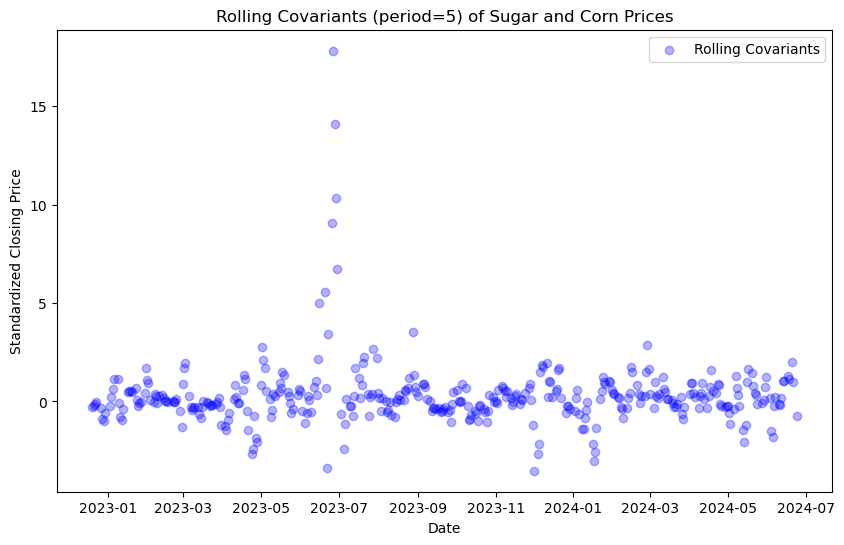

In [ ]:
# Now plot both standardized datasets
plt.figure(figsize=(10, 6))
plt.scatter(df_merged.index, rolling_cov, label='Rolling Covariants', color='blue',alpha=0.3)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Standardized Closing Price')
plt.title('Rolling Covariants (period=5) of Sugar and Corn Prices')
plt.legend()
plt.show()
